# ML Zoomcamp Homework 4

## Preparation

In [5]:
#getting the data
#!wget -O ../data/credit-card.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 11:39:50--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘../data/credit-card.csv’

../data/credit-card 100%[===================>]  71.53K  --.-KB/s    in 0.002s  

2022-10-03 11:39:50 (37.0 MB/s) - ‘../data/credit-card.csv’ saved [73250/73250]



In [1]:
# listing the data folder
!ls ../data

car-prices.csv	credit-card.csv  housing.csv


## Importing

In [2]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

## Loading Data

In [3]:
df = pd.read_csv('../data/credit-card.csv')

In [4]:
df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


## Preparing Data

In [5]:
df['card'].value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [6]:
df['card'] = df['card'].apply(lambda x: 1 if x == 'yes' else 0)
df['card'].value_counts()

1    1023
0     296
Name: card, dtype: int64

In [7]:
#df['majorcards'] = df['majorcards'].apply(lambda x: 'yes' if x == 1 else 0)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = \
        train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

In [9]:
num_variables = ['age', 'income', 'expenditure', 'share', 'dependents', 'months', 'active', 'reports']

In [10]:
results = {
    'feat': [],
    'auc': []
}
for feat in num_variables:
    auc = roc_auc_score(y_train, df_train[feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feat])
    results['feat'].append(feat)
    results['auc'].append(auc)

In [11]:
pd.DataFrame(results).sort_values('auc', ascending=False)

,feat,auc
2,expenditure,0.991042
3,share,0.989184
7,reports,0.716663
6,active,0.604317
1,income,0.590805
4,dependents,0.532776
5,months,0.529422
0,age,0.524002


In [12]:
df_train

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
1,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
2,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
3,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
4,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4
...,...,...,...,...,...,...,...,...,...,...,...
786,0,53.00000,2.4500,0.017718,35.67500,yes,no,0,3,1,11
787,2,30.58333,2.5000,0.000480,0.00000,no,no,0,12,1,18
788,0,24.75000,1.8750,0.080708,126.02250,no,no,1,14,0,1
789,1,56.91667,3.4838,0.062895,182.09580,yes,no,0,540,1,7


In [13]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [14]:
train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

In [15]:
round(roc_auc_score(y_val, y_pred), 4)

0.9952

## Question 3

In [16]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [17]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [18]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

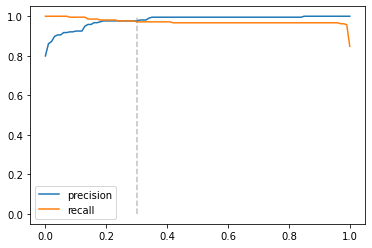

In [25]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Question 4

In [20]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

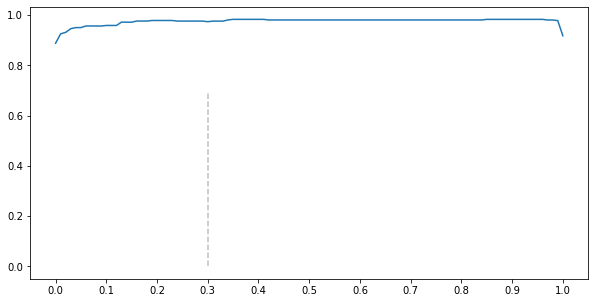

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Question 5

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.9919 +- 0.0056
C= 0.1, 0.9951 +- 0.0040
C=   1, 0.9964 +- 0.0027
C=  10, 0.9964 +- 0.0028
